In [ ]:
!pip install --upgrade linear-tree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pydotplus

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

https://data.ibb.gov.tr/dataset/istanbul-ilceleri-dogalgaz-kullanim-sinifi-kullanici-sayisi-tuketim-miktari/resource/86bc29a5-751a-4e83-a9de-0a103da94483?filters=Yil%3A2021

# Data Arranging

In [ ]:
xls = pd.ExcelFile("/content/drive/MyDrive/PROJ201/All_Data.xlsx")
meteodf = pd.read_excel("/content/drive/MyDrive/PROJ201/All_Data.xlsx", sheet_name=xls.sheet_names[0]).drop(columns="Unnamed: 0")
no2df = pd.read_excel("/content/drive/MyDrive/PROJ201/All_Data.xlsx", sheet_name=xls.sheet_names[1]).drop(columns="Unnamed: 0")
so2df = pd.read_excel("/content/drive/MyDrive/PROJ201/All_Data.xlsx", sheet_name=xls.sheet_names[2]).drop(columns="Unnamed: 0")
pm10df = pd.read_excel("/content/drive/MyDrive/PROJ201/All_Data.xlsx", sheet_name=xls.sheet_names[3]).drop(columns="Unnamed: 0")
gasconsumpdf = pd.read_excel("/content/drive/MyDrive/PROJ201/All_Data.xlsx", sheet_name=xls.sheet_names[5]).drop(columns="Unnamed: 0")
urbandf = pd.read_excel("/content/drive/MyDrive/PROJ201/All_Data.xlsx", sheet_name="Urban_Data")

wantedDistricts = ["Arnavutkoy", "Bagcilar", "Basaksehir", "Besiktas", "Esenler", "Fatih",
                   "Kadikoy", "Kartal", "Sancaktepe", "Sariyer", "Sultangazi",
                    "Umraniye", "Uskudar"]

## Meteorological Data

In [ ]:
# İstasyon Kodlarından ilçe bulma

districtlst = []
for i in meteodf.stationID:
  if i == 17814:
    districtlst.append("Gungoren")
  elif i == 17813:
    districtlst.append("Kadikoy")
  elif i == 17064:
    districtlst.append("Kartal")
  elif i == 17059 or i == 18980:
    districtlst.append("Sariyer")
  elif i == 18400:
    districtlst.append("Silivri")
  elif i == 18403:
    districtlst.append("Umraniye")
  elif i == 18402:
    districtlst.append("Arnavutkoy")
  elif i == 17060:
    districtlst.append("Bakırkoy")
  elif i == 18101:
    districtlst.append("Eyup")
  elif i == 18401:
    districtlst.append("Sisli")
  elif i == 18404:
    districtlst.append("Uskudar")
  elif i == 17603:
    districtlst.append("Fatih")
  elif i == 17454:
    districtlst.append("Fatih")
  elif i == 17062:
    districtlst.append("Kadikoy")
  elif i == 17064:
    districtlst.append("Kartal")
  elif i == 19112:
    districtlst.append("Kartal")
  elif i == 18399:
    districtlst.append("Sancaktepe")
  elif i == 17455:
    districtlst.append("Sariyer")
  elif i == 17061:
    districtlst.append("Sariyer")
  elif i == 17610:
    districtlst.append("Sile")
  elif i == 18792:
    districtlst.append("Sile")
  elif i == 18735:
    districtlst.append("Sile")
  elif i == 18400:
    districtlst.append("Silivri")
  elif i == 17438:
    districtlst.append("Silivri")
  elif i == 18793:
    districtlst.append("Silivri")
  elif i == 17388:
    districtlst.append("Silivri")
  elif i == 19365:
    districtlst.append("Sariyer")
  elif i == 18403:
    districtlst.append("Sariyer")
meteodf["district"] = districtlst

In [ ]:
# ayrı iki yağış değerini birleştirdim
meteodf["total_precip"] = meteodf[["total_precip_manuel", "total_precip_omgi"]].sum(axis=1, min_count=1)
meteodf = meteodf.drop(columns=["total_precip_manuel", "total_precip_omgi", "evapo",
                                "max_temp", "min_temp"])

In [ ]:
meteodf["date"] = pd.to_datetime(meteodf.date)

## Air Pollutors

In [ ]:
# FOR AIR POLLUTORS ONLY
def arrangeAirPollutors(df):
  df = df.rename({"Basaksehir_MTHM": "Basaksehir", "Catladikapi": "Fatih_Catladikapi",
                       "Goztepe": "Kadikoy_Goztepe", "Kandilli_MTHM": "Uskudar_Kandilli",
                       "Maslak": "Sariyer_Maslak", "Aksaray": "Fatih_Aksaray", "Selimiye": "Kadikoy_Selimiye",
                       "Silivri_MTHM": "Silivri", "Sultangazi_MTHM": "Sultangazi",
                       "Sile_MTHM":"Sile", "Umraniye_MTHM":"Umraniye",
                       "Uskudar_MTHM": "Uskudar_2", "Kadikoy":"Kadikoy_1",
                      "Uskudar": "Uskudar_1", "Sariyer": "Sariyer_1"}, axis=1)

  # Getting mean for districts who have multiple stations
  for i in range(len(df.columns)):
    col1 = df.columns[i]
    for col2 in df.columns[i+1:]:
      if col2.split("_")[0] == col1.split("_")[0]:
        df[col2.split("_")[0]] = np.nanmean(df[[col1,col2]].to_numpy(), axis=1)
  try:
    df = df[wantedDistricts+["date"]]
  except:
    # in case of O3
    realwant = wantedDistricts+["date"]
    realwant.remove('Umraniye')
    realwant.remove('Uskudar')
    df =  df[realwant]
  return df

In [ ]:
no2df = arrangeAirPollutors(no2df)
so2df = arrangeAirPollutors(so2df)
pm10df = arrangeAirPollutors(pm10df)

## Gas Consumption

In [ ]:
gasconsumpdf = gasconsumpdf.rename({"province": "district"}, axis=1)
gasconsumpdf = gasconsumpdf[gasconsumpdf.district.isin(wantedDistricts)]
gasconsumpdf["natural_gas_consumption"] = gasconsumpdf.natural_gas_consumption.astype("float")
gasconsumpdf["natural_gas_consumption"] /= 10**3

In [ ]:

"""newgasdf = pd.DataFrame()
for name in gasconsumpdf.district.unique():
  df = gasconsumpdf[gasconsumpdf.district == name]
  df = df.drop(columns = "district")
  df = df.rename(columns={"natural_gas_consumption":name})
  try:
    newgasdf = pd.merge(newgasdf, df, on = "date")
  except:
    newgasdf = df

newgasdf = newgasdf.rename(columns={"date": "date1"})
gas_daily = newgasdf.set_index("date1").resample('D').ffill()/30
gas_daily /= 10**3
gas_daily["date"] = pd.to_datetime(gas_daily.index)"""

'newgasdf = pd.DataFrame()\nfor name in gasconsumpdf.district.unique():\n  df = gasconsumpdf[gasconsumpdf.district == name]\n  df = df.drop(columns = "district")\n  df = df.rename(columns={"natural_gas_consumption":name})\n  try:\n    newgasdf = pd.merge(newgasdf, df, on = "date")\n  except:\n    newgasdf = df\n\nnewgasdf = newgasdf.rename(columns={"date": "date1"})\ngas_daily = newgasdf.set_index("date1").resample(\'D\').ffill()/30\ngas_daily /= 10**3\ngas_daily["date"] = pd.to_datetime(gas_daily.index)'

## Urban Data

In [ ]:
urbandf

,İlçeler,Özel Aracı Olanlar 2019,Ortalama Hanehalkı Büyüklüğü 2021,SEGE Skoru 2022,Ortalama Hanehalkı Büyüklüğü 2022,Nüfus 2022,Yıllık Nüfus Artış Yüzdesi 2022,Doğalgaz Abone Sayısı 2022,Hane Sayısı,Nüfus 2021,Nüfus 2020
0,Kadikoy,597,2.35,4.910,2.32,483064,-4.480038,296833,1008,485233,481983
1,Umraniye,546,3.26,3.364,3.20,732379,7.704592,309162,9340,726758,713803
2,Uskudar,538,2.95,3.045,2.92,524452,-1.796453,246721,4651,525395,520771
3,Sariyer,463,2.94,3.249,2.90,350454,1.387735,195701,2241,349968,335298
4,Kartal,449,3.02,2.321,2.97,483418,5.559281,217758,4758,480738,474514
5,Basaksehir,438,3.65,3.468,3.64,514900,22.899552,195323,5720,503243,469924
6,Sultangazi,424,3.94,0.816,3.86,542531,-1.563664,182067,13331,543380,537488
7,Sancaktepe,377,3.56,1.275,3.52,489848,31.479527,178203,11556,474668,456861
8,Esenler,338,3.66,1.354,3.58,445421,-3.798166,156768,9797,447116,446276
9,Besiktas,265,2.36,5.940,2.33,175190,-21.168278,138419,265,178938,176513


In [ ]:
urbandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   İlçeler                            13 non-null     object 
 1   Özel Aracı Olanlar 2019            13 non-null     int64  
 2   Ortalama Hanehalkı Büyüklüğü 2021  13 non-null     float64
 3   SEGE Skoru 2022                    13 non-null     float64
 4   Ortalama Hanehalkı Büyüklüğü 2022  13 non-null     float64
 5   Nüfus 2022                         13 non-null     int64  
 6   Yıllık Nüfus Artış Yüzdesi 2022    13 non-null     float64
 7   Doğalgaz Abone Sayısı 2022         13 non-null     int64  
 8   Hane Sayısı                        13 non-null     int64  
 9   Nüfus 2021                         13 non-null     int64  
 10  Nüfus 2020                         13 non-null     int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 1.2+ KB


In [ ]:
urbandf = urbandf.rename(columns={'SEGE Skoru 2022 ': "SEGE Skoru 2022",
                                  "İlçeler":  "date"})

In [ ]:
# FOR NÜFUS YIL SHIFTING
urbandf = urbandf.rename(columns={"Nüfus 2022": "Nüfus 2023",
                                  "Nüfus 2021": "Nüfus 2022",
                                  "Nüfus 2020": "Nüfus 2021"})

In [ ]:
def differUrban(columns, yearlst = None):
  if yearlst == None:
    yearlst = [int(x[-4:]) for x in columns]
  columns.append("date")
  nufusdf = urbandf[columns]
  nufusdf = nufusdf.T
  nufusdf.columns = nufusdf.loc["date"]
  nufusdf = nufusdf.drop("date")
  nufusdf.index = yearlst
  nufusdf.index = pd.to_datetime({"year" : nufusdf.index, "month" : 1, "day" : 1})
  nufusdf["date"] = nufusdf.index
  return nufusdf

In [ ]:
#nufusdf = differUrban(["Nüfus 2020", "Nüfus 2021", "Nüfus 2022"])
nufusdf = differUrban(["Nüfus 2023", "Nüfus 2021", "Nüfus 2022"])
hanesizedf = differUrban(['Ortalama Hanehalkı Büyüklüğü 2021', 'Ortalama Hanehalkı Büyüklüğü 2022'])
hanesaydf = differUrban(["Hane Sayısı"], [2022])
segedf = differUrban(["SEGE Skoru 2022"])

# Merging Data

In [ ]:
def arrangebyStation(district, gas_daily, yparam):
  try:
    df = meteodf.groupby("district").get_group(district).merge(gas_daily[[district, "date"]], on = "date", how="outer")
  except KeyError:
    # En yakın istasyon
    if district == "Bagcilar":
      name = 17814
    elif district == "Basaksehir" or district == "Sultangazi":
      name = 18101
    elif district == "Besiktas":
      name = 18401
    elif district == "Esenler":
      name = 17814

    df = meteodf.groupby("stationID").get_group(name).merge(gas_daily[[district, "date"]], on = "date", how="outer")
  df = df.drop(columns=["stationID", "station"])
  df = df.rename(columns={district : yparam})
    #print("For {} district there is no meteorological data".format(district))
  df["NO2"] = no2df[district]
  df["PM10"] = pm10df[district]
  df["SO2"] = so2df[district]

  return df

In [ ]:
districtsDict = {}
for district in wantedDistricts:
  df = arrangebyStation(district, nufusdf, "population")
  districtsDict[district] = df

In [ ]:
for district in wantedDistricts:
  df = districtsDict[district].merge(hanesizedf[[district, "date"]], on = "date", how="outer")
  df = df.rename(columns={district : "household_size"})

  df = df.merge(hanesaydf[[district, "date"]], on = "date", how="outer")
  df = df.rename(columns={district : "household_num"})

  df = df.merge(segedf[[district, "date"]], on = "date", how="outer")
  df = df.rename(columns={district : "sege"})

  districtsDict[district] = df

In [ ]:
def fillingNAN(district):
  data = districtsDict[district]
  data = data[data.date < "2023-11-01"].drop(columns=["total_precip", "district"])
  data = data.set_index("date")

  for i in data.columns:
    if i in ["population", "household_size", "household_num", "sege"]:
      data[i] = data[i].ffill()
    else:
      data[i] = data[i].interpolate()
    if data[i].isna().sum() != 0:
      data[i] = data[i].fillna(data[i].mean())
    if data[i].isna().sum() == data[i].shape[0]: # Bazı O3ler için
      data = data.drop(columns=i)
  #data.to_csv("output_"+district+".csv")
  districtsDict[district] = data.sort_index()

In [ ]:
for district in districtsDict.keys():
  fillingNAN(district)
  districtsDict[district]["district"] = district
  districtsDict[district]["date"] = districtsDict[district].index

In [ ]:
df = pd.concat(districtsDict.values(), ignore_index=True)

In [ ]:
df = df.merge(gasconsumpdf, on=["date", "district"], how="outer")
df = df.drop([19708, 19709, 19710])
df = df.fillna(method="ffill")

In [ ]:
df = df[["mean_temp", "rel_hum", "population", "NO2", "SO2", "sege",
    "household_size", "household_num", "PM10", "natural_gas_consumption"]]

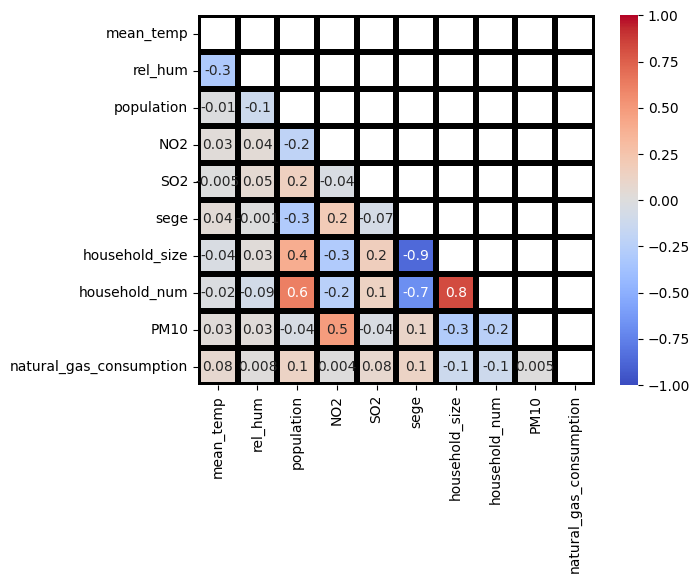

In [ ]:
f, ax = plt.subplots()
sns.heatmap(df.corr(), annot=True, fmt='.1g',
            vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',
            linewidths=3, linecolor='black', ax=ax,
            mask=np.triu(np.ones_like(df.corr())))
plt.savefig("/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/tree_label_correlation.png")
plt.show()

# Regression 1

In [ ]:
def automaticRegression(col, path, min_samples_leaf = 1, max_depth = None):
  X = df.drop(columns=col)
  y = df[[col]]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  reg = DecisionTreeRegressor(min_samples_leaf = min_samples_leaf,
                              max_depth = max_depth)
  reg.fit(X_train, y_train)
  y_pred1 = reg.predict(X_test)
  dotdata = export_graphviz(reg, feature_names = X.columns)
  graph = pydotplus.graph_from_dot_data(dotdata)
  graph.write_png(path+".png")
  return r2_score(y_test, y_pred1), mean_squared_error(y_test, y_pred1), reg.tree_.feature

In [ ]:
accdf = pd.DataFrame(columns=["r2_score", "mse_score"])
for col in df.columns:
  path = "/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/dt_tree_{}".format(col)
  r1, r2 = automaticRegression(col, path)
  accdf.loc[col, "r2_score"] = r1
  accdf.loc[col, "mse_score"] = r2

accdf

In [ ]:
acc1df = pd.DataFrame(columns=["r2_score", "mse_score"])
for col in df.columns:
  path = "/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/dt_tree_after_{}".format(col)
  r1, r2 = automaticRegression(col, path, min_samples_leaf = 200, max_depth = 7)
  acc1df.loc[col, "r2_score"] = r1
  acc1df.loc[col, "mse_score"] = r2

acc1df

,r2_score,mse_score
mean_temp,0.12248,45.69913
rel_hum,0.24492,109.236239
population,0.99469,85461386.449672
NO2,0.718919,219.549204
SO2,0.316555,109.48839
sege,1.0,0.0
household_size,0.999685,0.000073
household_num,1.0,0.0
PM10,0.811114,229.838044
natural_gas_consumption,0.229173,121946303.783331


# Data Manipulating and Regression 2

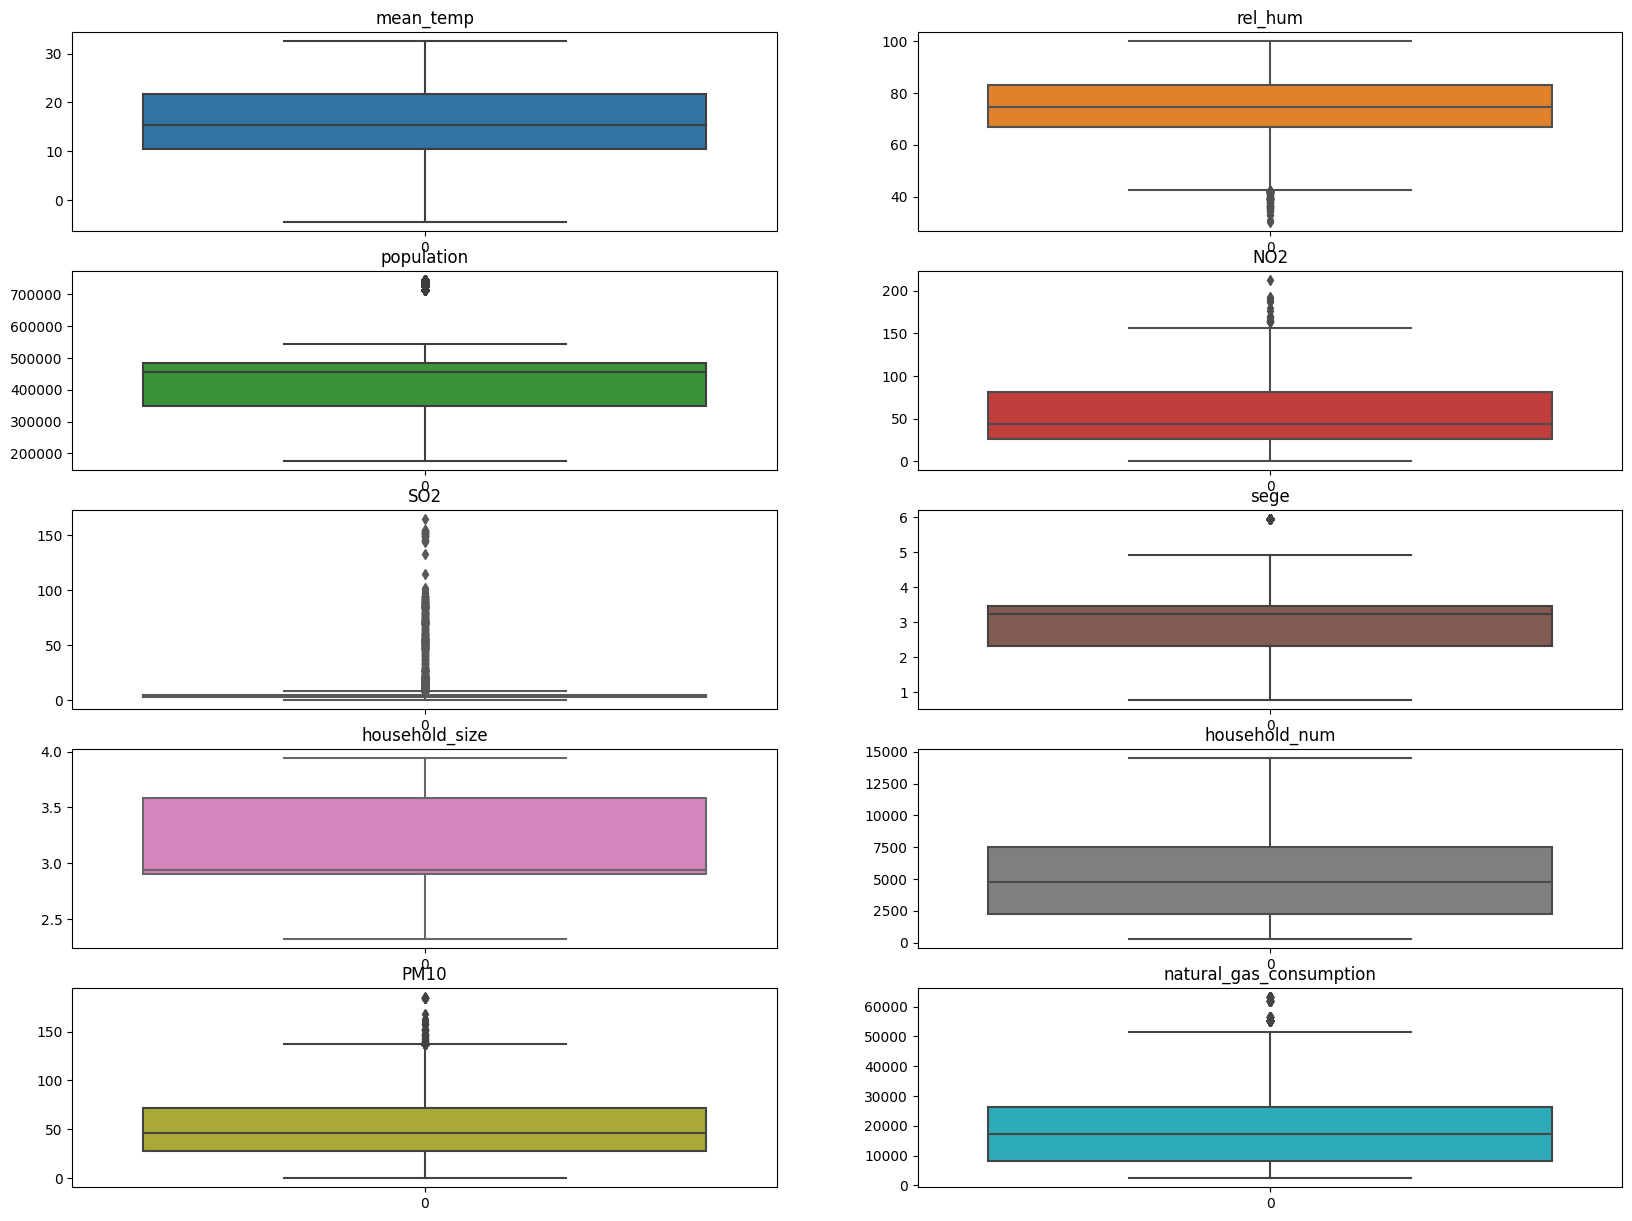

In [ ]:
f, ax = plt.subplots(5,2, figsize=(20,15))
i=0
j=0
k=0
for col in df.columns:
  sns.boxplot(df[col], ax=ax[j][i],
              color = sns.color_palette("tab10")[k]).set(title=col)
  i+=1
  k+=1
  if i == 2:
    i =0
    j+=1
plt.show()

In [ ]:
def airFilter(s):
  s = s.mask(s <= 50, 0)
  s = s.mask((s <= 100) & (s > 50), 1)
  s = s.mask((s <= 150) & (s > 100), 2)
  s = s.mask((s <= 200) & (s > 150), 3)
  s = s.mask((s <= 300) & (s > 200), 4)
  s = s.mask((s <= 500) & (s > 300), 5)
  return s

def categorizer(s, num, labels = None):
  if labels == None:
    if type(num) == int:
      labels = range(num)
    else:
      labels = range(len(num)-1)
  return pd.qcut(s, num, labels = labels, retbins=True)

In [ ]:
def choosingBestSeperator(dfmain, col, isairFilter = False, issegeFilter = False):
  dfdene = dfmain.copy()
  if issegeFilter:
    dfdene["sege"] = dfdene.sege.mask(dfdene.sege > 1.5, 1).mask(dfdene.sege <= 1.5, 2) # according to sege reports
    if col == "sege":
      raise ValueError("Column cannot be 'sege' since issegeFilter is True")
  if isairFilter:
    dfdene["NO2"] = airFilter(dfdene.NO2)
    dfdene["SO2"] = airFilter(dfdene.SO2)
    dfdene["PM10"] = airFilter(dfdene.PM10)
    if col in ["NO2", "SO2", "PM10"]:
      raise ValueError("Column cannot be an air pollutant since isairFilter is True")

  accdf = pd.DataFrame(columns=["r2_score", "mse_score", "param", "features", "bins"])
  for n in range(2,10):
    try:
      dfdene[col], bins = categorizer(dfdene[col], n)
      path = "/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/Data Manipulating/dt_{}_q_{}".format(col,n)
      r1, r2, feature = automaticRegression(col, path, min_samples_leaf = 200, max_depth = 7)
      accdf.loc[n, "r2_score"] = r1
      accdf.loc[n, "mse_score"] = r2
      accdf.loc[n, "features"] = [dfdene.columns[x] for x in np.unique(feature)]
      accdf.loc[n, "bins"] = bins
    except ValueError:
      continue
    dfdene[col] = dfmain[col]
  accdf["param"] = col
  accdf["split"] = accdf.index
  return accdf

In [ ]:
conlst = []
for col in ["population", "sege", "household_num", "household_size"]:
  accdf = choosingBestSeperator(df, col, isairFilter = True)
  conlst.append(accdf)
  print(col, "is finished")

population is finished
sege is finished
household_num is finished
household_size is finished


In [ ]:
pd.concat(conlst)

,r2_score,mse_score,param,features,bins,split
2,0.99469,85461386.449672,population,"[PM10, rel_hum, population, NO2, SO2, sege, ho...","[175190.0, 456861.0, 744351.0]",2
3,0.99469,85461386.449672,population,"[PM10, rel_hum, population, NO2, SO2, sege, ho...","[175190.0, 350454.0, 483064.0, 744351.0]",3
4,0.99469,85461386.449672,population,"[PM10, rel_hum, population, NO2, SO2, sege, ho...","[175190.0, 349968.0, 456861.0, 485233.0, 74435...",4
5,0.99469,85461386.449672,population,"[PM10, rel_hum, population, NO2, SO2, sege, ho...","[175190.0, 349968.0, 382990.0, 480738.0, 51490...",5
6,0.99469,85461386.449672,population,"[PM10, rel_hum, population, NO2, SO2, sege, ho...","[175190.0, 335298.0, 350454.0, 456861.0, 48306...",6
7,0.99469,85461386.449672,population,"[PM10, rel_hum, population, NO2, SO2, sege, ho...","[175190.0, 335298.0, 349968.0, 396594.0, 47466...",7
8,0.99469,85461386.449672,population,"[PM10, rel_hum, population, NO2, SO2, sege, ho...","[175190.0, 335298.0, 349968.0, 368227.0, 45686...",8
9,0.99469,85461386.449672,population,"[PM10, rel_hum, population, NO2, SO2, sege, ho...","[175190.0, 335298.0, 349968.0, 350454.0, 44542...",9
2,1.0,0.0,sege,"[PM10, mean_temp, rel_hum, population, NO2, SO...","[0.771, 3.2489999999999997, 5.94]",2
3,1.0,0.0,sege,"[PM10, mean_temp, rel_hum, population, NO2, SO...","[0.771, 2.346, 3.363999999999999, 5.94]",3


In [ ]:
df["NO2"] = airFilter(df.NO2)
df["SO2"] = airFilter(df.SO2)
df["PM10"] = airFilter(df.PM10)
df["sege"], bin1 = categorizer(df.sege, 8)
df["household_size"], bin2 = categorizer(df.household_size, 5)
df["household_num"], bin3 = categorizer(df.household_num, 4)
df["population"], bin4 = categorizer(df["population"], 4)
df["natural_gas_consumption"], bin5 = categorizer(df["natural_gas_consumption"], 5)
d = {"sege": bin1, "household_size": bin2, "household_num": bin3, "population":bin4,
     "natural_gas_consumption": bin5}
path = "/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/Data Manipulating/BEST_".format(col)
r1, r2, feature = automaticRegression("sege", path, min_samples_leaf = 200, max_depth = 7)

In [ ]:
seriesdict = {}
for key in d.keys():
  label = pd.Series()
  for i in range(len(list(d[key]))-1):
    label.loc[i] = str(round(list(d[key])[i],2))+"-"+str(round(list(d[key])[i+1],2))
  seriesdict[key]= label
parcadf = pd.DataFrame(seriesdict)
parcadf

,sege,household_size,household_num,population,natural_gas_consumption
0,0.77-1.27,2.32-2.84,265.0-2241.0,175190.0-349968.0,2394.93-5804.6
1,1.27-2.32,2.84-2.92,2241.0-4758.0,349968.0-456861.0,5804.6-13239.42
2,2.32-3.04,2.92-2.97,4758.0-7546.0,456861.0-485233.0,13239.42-19910.85
3,3.04-3.25,2.97-3.64,7546.0-14491.0,485233.0-744351.0,19910.85-29990.46
4,3.25-3.25,3.64-3.94,NaN,NaN,29990.46-63135.69
5,3.25-3.47,NaN,NaN,NaN,NaN
6,3.47-4.91,NaN,NaN,NaN,NaN
7,4.91-5.94,NaN,NaN,NaN,NaN


In [ ]:
parcadf.T.to_excel("parca.xlsx")

In [ ]:
print("R square:", r1, "- Mean Square Error:", r2)

R square: 0.9374743860572391 - Mean Square Error: 0.3496545337550644


In [ ]:
[df.columns[x] for x in np.unique(feature)]

['PM10',
 'mean_temp',
 'rel_hum',
 'population',
 'NO2',
 'sege',
 'household_size',
 'household_num',
 'PM10']

In [ ]:
path = "/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/Data Manipulating/BEST2_".format(col)
r1, r2, feature = automaticRegression("household_num", path, min_samples_leaf = 200, max_depth = 7)

In [ ]:
print("R square:", r1, "- Mean Square Error:", r2)

R square: 0.990230187261026 - Mean Square Error: 0.01486332257819861


In [ ]:
[df.columns[x] for x in np.unique(feature)]

['PM10', 'rel_hum', 'population', 'NO2', 'sege', 'household_size', 'PM10']

In [ ]:
path = "/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/Data Manipulating/BEST3_".format(col)
r1, r2, feature = automaticRegression("population", path, min_samples_leaf = 200, max_depth = 7)
print("R square:", r1, "- Mean Square Error:", r2)
print([df.columns[x] for x in np.unique(feature)])

R square: 0.9377082572144382 - Mean Square Error: 0.08110917287162382
['PM10', 'mean_temp', 'rel_hum', 'SO2', 'sege', 'household_size', 'household_num', 'PM10']


In [ ]:
path = "/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/Data Manipulating/BEST4_".format(col)
r1, r2, feature = automaticRegression("household_size", path, min_samples_leaf = 200, max_depth = 7)
print("R square:", r1, "- Mean Square Error:", r2)
print([df.columns[x] for x in np.unique(feature)])

R square: 0.9862809984403889 - Mean Square Error: 0.028936020490997038
['PM10', 'rel_hum', 'population', 'sege', 'household_size', 'household_num', 'PM10']


# Denemeler

In [ ]:
df["household_num"] = categorizer(df["household_num"],  [0, .25, .5, .75, 1.])
df["household_size"] = categorizer(df["household_size"], 3)
df["sege"] = categorizer(df["sege"], 3)
df["population"] = categorizer(df["population"], 4)
df["mean_temp"] = categorizer(df["mean_temp"], 4)
df["rel_hum"] = categorizer(df["rel_hum"], 4)
df["natural_gas_consumption"] = categorizer(df["natural_gas_consumption"], 5)
df["NO2"] = airFilter(df.NO2)
df["SO2"] = airFilter(df.SO2)
df["PM10"] = airFilter(df.PM10)

In [ ]:


df["household_num"] = categorizer(df["household_num"],  [0, .25, .5, .75, 1.])
df["household_size"] = categorizer(df["household_size"], 3)
df["sege"] = categorizer(df["sege"], 3)
df["population"] = categorizer(df["population"], 4)
df["mean_temp"] = categorizer(df["mean_temp"], 4)
df["rel_hum"] = categorizer(df["rel_hum"], 4)
df["natural_gas_consumption"] = categorizer(df["natural_gas_consumption"], 5)

In [ ]:
def automaticRegression(col):
  path = "/content/drive/MyDrive/PROJ201/Logistic_Tree_Regression/"
  X = df.drop(columns=col)
  y = df[[col]]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  reg = DecisionTreeRegressor(min_samples_leaf = 200, max_depth = 7)
  reg.fit(X_train, y_train)
  y_pred1 = reg.predict(X_test)
  dotdata = export_graphviz(reg, feature_names = X.columns)
  graph = pydotplus.graph_from_dot_data(dotdata)
  graph.write_png(path+"dt_tree_after_{}.png".format(col))

  """  reg = LinearTreeRegressor(base_estimator=LinearRegression())
    reg.fit(X, y)
    y_pred2 = reg.predict(X_test)
    reg.model_to_dot(feature_names=X.columns).write_png(path+"lt_tree_{}.png".format(col))

    leaves = reg.summary(only_leaves=True)
    markers = '8s*+xv^.'
    plt.figure(figsize=(12,6))
    for m,(i,l) in enumerate(leaves.items()):
        plt.scatter(range(X.shape[1]), l['models'].coef_,
                    marker=markers[m], label="node {}".format(i))

    plt.axhline(0, c='black', linestyle='--', alpha=0.3)
    plt.title('coefficients in the leaves')
    plt.xticks(range(X.shape[1]), X.columns)
    plt.ylabel('coefficients'); plt.xlabel('features')
    plt.legend()
    plt.savefig(path+"lt_tree_coef_{}.png".format(col))

    return [r2_score(y_test, y_pred1),
            r2_score(y_test, y_pred2)]"""
  return r2_score(y_test, y_pred1), mean_squared_error(y_test, y_pred1)
r_sqrtdf = pd.DataFrame(columns=["r2_score"])
for col in df.columns:
  r1 = automaticRegression(col)
  r_sqrtdf.loc[col] = r1

r_sqrtdf

In [ ]:
"""d = {"dt": [], "lt": []}
for col in df.columns:
  r1, r2 = automaticRegression(col)
  d["dt"].append(r1)
  d["lt"].append(r2)

r_sqrtdf = pd.DataFrame(d)
r_sqrtdf"""

In [ ]:
X = df[["mean_temp", "rel_hum", "population", "NO2", "SO2", "PM10",
        "household_size", "household_num"]]
y = df[["sege"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(r2_score(y_test, y_pred))

1.0


In [ ]:
export_graphviz(reg, out_file ='tree_afterlabel.dot',
               feature_names = X.columns)

In [ ]:
reg = LinearTreeRegressor(base_estimator=LinearRegression())
reg.fit(X, y)
y_pred = reg.predict(X_test)
print(r2_score(y_test, y_pred))

0.999999922435168


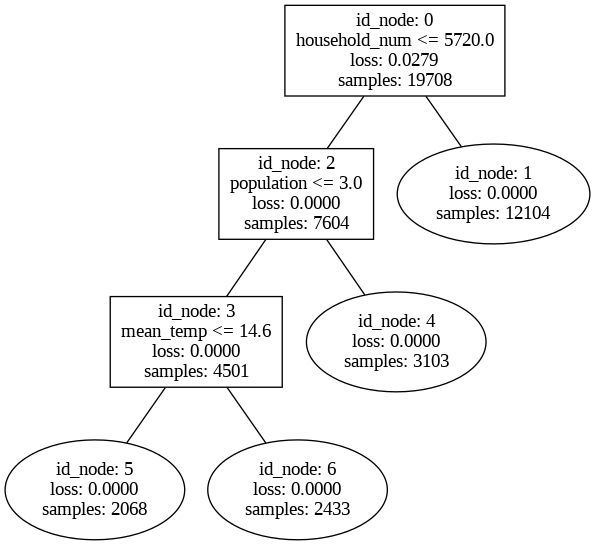

In [ ]:
reg.plot_model(feature_names=X.columns)

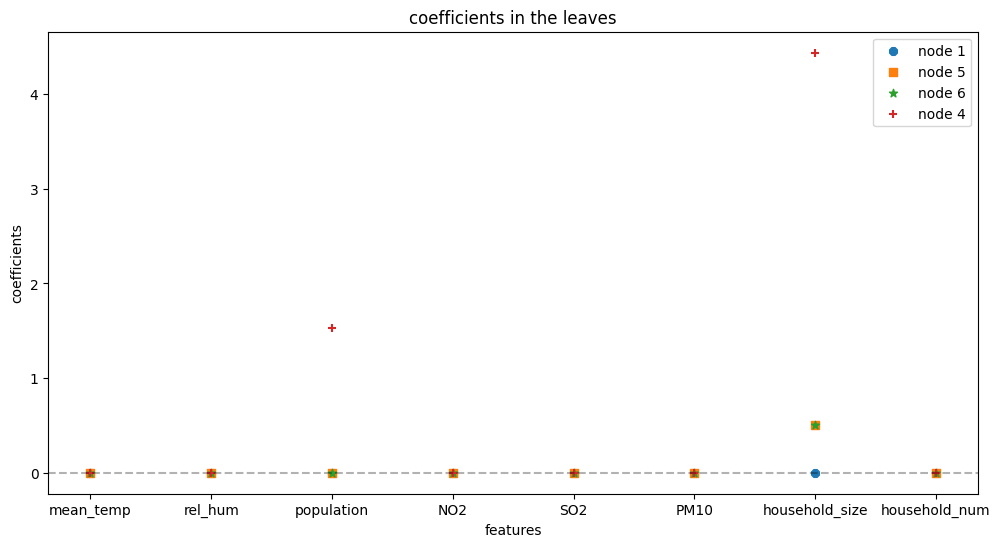

In [ ]:
leaves = reg.summary(only_leaves=True)
markers = '8s*+xv^.'

plt.figure(figsize=(12,6))
for m,(i,l) in enumerate(leaves.items()):
    plt.scatter(range(X.shape[1]), l['models'].coef_,
                marker=markers[m], label="node {}".format(i))

plt.axhline(0, c='black', linestyle='--', alpha=0.3)
plt.title('coefficients in the leaves')
plt.xticks(range(X.shape[1]), X.columns)
plt.ylabel('coefficients'); plt.xlabel('features')
plt.legend()